In [1]:
import glob

In [2]:
DATA_PATH = "../data/eva/"

import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
TEST_TXT = f"{DATA_PATH}clean/test.txt"
TRAIN_TXT = f"{DATA_PATH}clean/train.txt"
OLD_TXT = TRAIN_TXT

train_paths = glob.glob(f"{DATA_PATH}proc/*.txt")
test_path = f"{DATA_PATH}proc/test/test_once_dataset_2x.txt"

train_txt = ""
length = {}
for path in train_paths:
    with open(path, "r") as f:
        text = f.read()
        text = text.replace("\n\n", "\n").replace("\n\n", "\n")
        length[path.split("/")[-1].split(".")[0]] = len(text.split("\n"))
        train_txt += text
with open(TRAIN_TXT, "w") as f:
    f.write(train_txt)

with open(test_path, "r") as f:
    text = f.read()
    text = text.replace("\n\n", "\n").replace("\n\n", "\n")


with open(TEST_TXT, "w") as f:
    f.write(text)

with open(TRAIN_TXT, "r") as f:
    text = f.read()
    dialogs = [d.split("\n") for d in text.split("<s>") if d]
    dialogs = ["\n".join([d[0]] + [""] + d[1:]) for d in dialogs]
    text = "<s>".join(dialogs)

with open(TRAIN_TXT, "w") as f:
    f.write(text)

with open(TEST_TXT, "r") as f:
    text = f.read()
    dialogs = [d.split("\n") for d in text.split("<s>") if d]
    dialogs = ["\n".join([d[0]] + [""] + d[1:]) for d in dialogs]
    text = "<s>".join(dialogs)

with open(TEST_TXT, "w") as f:
    f.write(text)

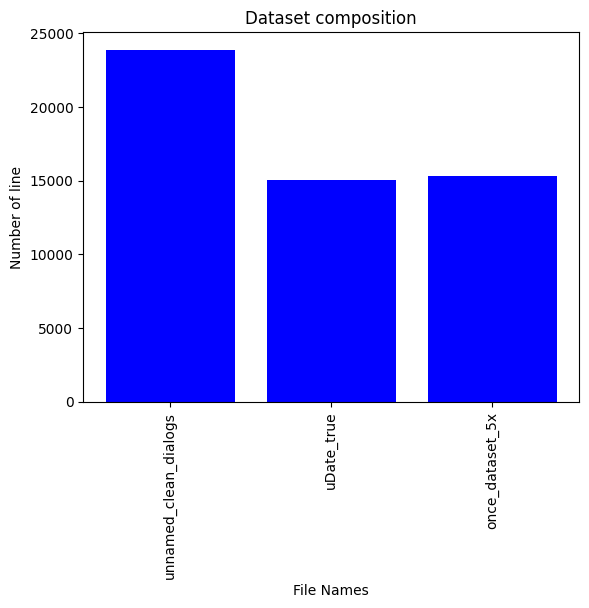

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

names = list(length.keys())
values = list(length.values())

# Creating the bar plot
# plt.figure(figsize=(10,5))
plt.bar(names, values, color='blue')

plt.xlabel('File Names')
plt.ylabel('Number of line')
plt.title('Dataset composition')
plt.xticks(rotation=90)  # Rotate labels for better readability
plt.show()

In [5]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM

from torch.optim import Optimizer
from typing import Callable, Iterable, Tuple
from torch.distributions.bernoulli import Bernoulli
import math

import os

/home/smurzakhmetov/anaconda3/envs/llama_stable/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
torch.cuda.is_available()

True

In [7]:
name = "TheBloke/Llama-2-7B-fp16"
DATA_PATH = "../data/"
TRAIN_TXT = f"{DATA_PATH}/clean/train.txt"


with open(TEST_TXT, "r") as f:
    text = f.read()
    text = text.replace("<|endoftext|>", "<s> ")
    text = text.replace("\n\n", "\n").replace("\n\n", "\n")

with open(TEST_TXT, "w") as f:
    f.write(text)


with open(TRAIN_TXT, "r") as f:
    text = f.read()
    text = text.replace("<|endoftext|>", "<s> ")
    text = text.replace("\n\n", "\n").replace("\n\n", "\n")

with open(TRAIN_TXT, "w") as f:
    f.write(text)

### Prepare data for training

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForCausalLM.from_pretrained(name).half()

Loading checkpoint shards:   0%|                                                                                                                                                                                                                                                                    | 0/2 [00:00<?, ?it/s]/home/smurzakhmetov/anaconda3/envs/llama_stable/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

# Optimizer

# Freezing

In [9]:
from torch.utils.data import Dataset
import random


class MyDataset:
    def __init__(self, path):
        super().__init__()
        with open(path) as f:
            text = f.read()
        dialogs = text.split("<s> ")
        dialogs = ["<s> " + "\n".join(dialog.strip(" ").split("\n")[1:]) for dialog in dialogs if len(dialog) > 100]
        # for i in range(len(dialogs)):
        #     if dialogs[i][-1] != "\n":
        #         dialogs[i] = dialogs[i] + "\n"
        self.dialogs = dialogs

    def __len__(self):
        return len(self.dialogs)

    def __getitem__(self, i):
        dialog = self.dialogs[i]
        # print(dialog)
        tokens = tokenizer.encode(dialog, add_special_tokens=False, return_tensors="pt")
        # print(tokens)
        N = random.choice([2048])
        if len(tokens[0]) > N:
            # print("AAA")
            dialog_lines = dialog.split("\n")
            prompt = dialog_lines[0:1]
            lines = dialog_lines[1:]
            idx = random.randint(0, len(lines) - 5)
            idx = random.choice([0, idx, idx])
            new_lines = lines[idx : idx + 5]
            dialog = "\n".join(prompt + new_lines)
            dialog = "\n".join(prompt + new_lines)
            tokens = tokenizer.encode(dialog, add_special_tokens=False, return_tensors="pt")
        return tokens[0]

In [10]:
dataset = MyDataset(TRAIN_TXT)

In [11]:
from tqdm import tqdm

lengths = []
for i in tqdm(range(len(dataset)), total=len(dataset)):
    lengths.append(len(dataset[i]))
print(max(lengths))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1206/1206 [00:07<00:00, 156.91it/s]

2034


# Training args

In [12]:
from transformers import TextDataset, DataCollatorForLanguageModeling

In [13]:
args = {
    "epochs": 1,
    "bs": 1,
    "warmup": 0.1,
    "grad_accum": 1,
    "lr": 2 * 1e-6,
    "tokens": 2048,
    "training": False,
}

train_dataset = dataset  # TextDataset(tokenizer=tokenizer,file_path=TRAIN_TXT, block_size=args["tokens"])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

model.training = args["training"]
# model.to(DEVICE);

In [14]:
DEVICE = torch.device("cuda:0")

In [15]:
from torch import nn
from transformers import Trainer

a = [0]


class CustomTrainer(Trainer):
    @staticmethod
    def subfinder(mylist, start, finish):
        matches = []
        match = []
        for i in range(len(mylist)):
            if mylist[i] == start[0] and mylist[i : i + len(start)] == start:
                match.append(i + len(start))
            if mylist[i] == finish[0] and mylist[i : i + len(finish)] == finish:
                match.append(i + len(finish))
                if len(match) == 2:
                    matches.append(match)
                match = []
        return matches

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        logits = logits[..., :-1, :].contiguous()
        labels = labels[..., 1:].contiguous()
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(reduction="none")
        start = [29901]
        finish = [13]
        # a[0] = [logits, labels]
        ids = self.subfinder(list(labels.squeeze(0).cpu().numpy()), start, finish)
        mask = torch.zeros(len(labels.squeeze(0))).to(DEVICE)
        for i1, i2 in ids:
            mask[i1:i2] += 1
        if mask.sum() < 1:
            mask += 1
            print(labels)

        # loss = loss_fct(logits.view(-1, self.model.config.vocab_size), labels.view(-1))
        loss = loss_fct(logits.view(-1, self.model.config.vocab_size), labels.view(-1).long())

        loss *= mask
        loss = loss.sum() / mask.sum()
        # print("C", loss)
        return (loss, outputs) if return_outputs else loss

# Training 

In [16]:
if hasattr(model, "enable_input_require_grads"):
    model.enable_input_require_grads()
else:

    def make_inputs_require_grad(module, input, output):
        output.requires_grad_(True)

    model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

In [17]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
 

In [18]:
unfreeze = ["self_attn", "mlp", "input_layernorm"]  # ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj']


def freeze(model, unfreeze):
    for name, p in model.named_parameters():
        name = name.lower()
        p.requires_grad = False
        for target in unfreeze:
            if target in name:
                p.requires_grad = True
    return model


model = freeze(model, unfreeze)

In [19]:
from transformers import Trainer, TrainingArguments

In [20]:
path = "checkpoints/"
training_args = TrainingArguments(
    do_train=True,
    do_eval=True,
    do_predict=True,
    gradient_checkpointing=True,
    output_dir=path,
    overwrite_output_dir=True,
    num_train_epochs=args["epochs"],
    per_device_train_batch_size=args["bs"],
    per_device_eval_batch_size=args["bs"],
    warmup_ratio=args["warmup"],
    gradient_accumulation_steps=args["grad_accum"],
    optim="adafactor",
    learning_rate=args["lr"],
    # use_cache = False,
    logging_steps=250,
    save_steps=250,
    # eval_steps = 250,
    # evaluation_strategy="steps",
    fp16=False,
)


trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [21]:
output = trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/smurzakhmetov/anaconda3/envs/llama_stable/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
250,1.987100
500,1.879300
750,1.812500
1000,1.773100


Checkpoint destination directory checkpoints/checkpoint-250 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/home/smurzakhmetov/anaconda3/envs/llama_stable/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


tensor([[29871]], device='cuda:0')


Checkpoint destination directory checkpoints/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/home/smurzakhmetov/anaconda3/envs/llama_stable/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


tensor([[29871]], device='cuda:0')
tensor([[29871]], device='cuda:0')


Checkpoint destination directory checkpoints/checkpoint-750 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/home/smurzakhmetov/anaconda3/envs/llama_stable/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


tensor([[29871]], device='cuda:0')
tensor([[29871]], device='cuda:0')


Checkpoint destination directory checkpoints/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/home/smurzakhmetov/anaconda3/envs/llama_stable/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [22]:
name = "llama-v2-base-dataset-no-system-prompt"
save_params = {
    "type": f"fine-tune",
    "Unfreeze": unfreeze,
    "datasets": "non_toxic.txt",
    "params": args,
    "loss": str(output),
}

import json

model.eval().save_pretrained(name)
tokenizer.save_pretrained(name)
# model.base_model.eval().save_pretrained(name)

with open(f"./{name}/params.json", "w") as f:
    json.dump(save_params, f)

In [23]:
with open("../1x-mini.txt", "r") as f:
    text = f.read()
    text = text.replace("<|endoftext|>", "<s> ")
dialogs = text.split("<s> ")[1:]


def evaluate_bleu_score(gold_caps, predictions, ngram=4):
    bleu_scores = []

    for reference_captions, pred_caption in zip(gold_caps, predictions):
        # Tokenize the reference and predicted captions
        tokenized_references = [nltk.word_tokenize(ref.lower()) for ref in reference_captions]
        tokenized_pred = nltk.word_tokenize(pred_caption.lower())

        # Compute the BLEU score for the prediction
        bleu_score = nltk.translate.bleu_score.sentence_bleu(
            tokenized_references, tokenized_pred, weights=[1 / ngram] * ngram
        )
        bleu_scores.append(bleu_score)

    # Calculate the average BLEU score
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu


true_answers = []
generated_answers = []

for dialog in tqdm(dialogs):
    input_text, cat_reply = dialog.split(f"{NAME}: ")

    input_text += f"{NAME}:"
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device)
    length = input_ids.shape[1]
    with torch.no_grad():
        out = model.generate(
            input_ids=input_ids,
            **high_params1,
        )

    generated = tokenizer.batch_decode(out[:, length:])  # tokenizer.decode(out[0][length:]).strip()
    generated = [text.strip() for text in generated]
    generated_answers += generated
    true_answers += [[cat_reply.strip()]] * len(generated)


bleu_1 = evaluate_bleu_score(true_answers, generated_answers, ngram=1)
bleu_2 = evaluate_bleu_score(true_answers, generated_answers, ngram=2)
bleu_3 = evaluate_bleu_score(true_answers, generated_answers, ngram=3)
bleu_4 = evaluate_bleu_score(true_answers, generated_answers, ngram=4)


with open("1x-super.txt", "r") as f:
    text = f.read()
    text = text.replace("<|endoftext|>", "<s> ")
    dialogs = text.split("<s> ")[1:]

true_answers = []
generated_answers = []

for dialog in dialogs:
    lines = dialog.split("\n")[:-1]
    for i in tqdm(range(1, len(lines) - 1, 2)):
        lines_part = lines[0:i]
        lines_part = [lines_part[0]] + lines_part[-7:]
        input_text = "\n".join(lines_part) + f"\n{NAME}:"
        cat_reply = lines[i].split(f"{NAME}: ")[1].strip()
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device)
        length = input_ids.shape[1]
        with torch.no_grad():
            out = model.generate(
                input_ids=input_ids,
                **high_params1,
            )

        generated = tokenizer.batch_decode(out[:, length:])  # tokenizer.decode(out[0][length:]).strip()
        generated = [text.strip() for text in generated]
        generated_answers += generated
        true_answers += [[cat_reply.strip()]] * len(generated)


super_bleu_1 = evaluate_bleu_score(true_answers, generated_answers, ngram=1)
super_bleu_2 = evaluate_bleu_score(true_answers, generated_answers, ngram=2)
super_bleu_3 = evaluate_bleu_score(true_answers, generated_answers, ngram=3)
super_bleu_4 = evaluate_bleu_score(true_answers, generated_answers, ngram=4)

print(
    {
        "bleu-1": bleu_1,
        "bleu-2": bleu_2,
        "bleu-3": bleu_3,
        "bleu-4": bleu_4,
        "super_bleu-1": super_bleu_1,
        "super_bleu-2": super_bleu_2,
        "super_bleu-3": super_bleu_3,
        "super_bleu-4": super_bleu_4,
    }
)

FileNotFoundError: [Errno 2] No such file or directory: '1x-mini.txt'